In [1]:
from flask import Flask, jsonify,request
import webbrowser
import urllib
import requests

In [2]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, os.path
import cv2
import random
from tensorflow.python.framework import ops

C:\Users\Mohamed\anaconda3\envs\pythonProject1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mohamed\anaconda3\envs\pythonProject1\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Mohamed\anaconda3\envs\pythonProject1\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(url):
    response = requests.get(url)
    
    name = "sample_image.jpg"

    file = open(name, "wb")
    file.write(response.content)
    file.close()
    return name

In [4]:
def read_image(path):
    img = cv2.imread(path,cv2.IMREAD_COLOR) 
    return img

In [5]:
def classify(image):
    img_width, img_height, img_num_channels = 50, 50, 3
    ops.reset_default_graph()
    #X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X") # original not working
    tf.compat.v1.disable_eager_execution()
    X = tf.compat.v1.placeholder(shape=[None, 50, 50, 3], dtype=tf.float32, name="X")
    caps1_n_maps = 32
    caps1_n_caps = caps1_n_maps * 17 * 17  # 1152 primary capsules
    caps1_n_dims = 8
    conv1_params = {
        "filters": 256,
        "kernel_size": 9,
        "strides": 1,
        "padding": "valid",
        "activation": tf.nn.relu,
    }

    conv2_params = {
        "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
        "kernel_size": 9,
        "strides": 2,
        "padding": "valid",
        "activation": tf.nn.relu
    }
    conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
    conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)
    caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                           name="caps1_raw")
    def squash(s, axis=-1, epsilon=1e-7, name=None):
    #with tf.name_scope(name, default_name="squash"):
        with tf.name_scope(name):
            #squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
            #                             keep_dims=True)
            squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                         keepdims=True)
            safe_norm = tf.sqrt(squared_norm + epsilon)
            squash_factor = squared_norm / (1. + squared_norm)
            unit_vector = s / safe_norm
            return squash_factor * unit_vector
    caps1_output = squash(caps1_raw, name="caps1_output")
    caps2_n_caps = 10
    caps2_n_dims = 16
    init_sigma = 0.1

    #W_init = tf.random_normal(
    W_init = tf.random.normal(
        shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
        stddev=init_sigma, dtype=tf.float32, name="W_init")
    W = tf.Variable(W_init, name="W")
    batch_size = tf.shape(X)[0]
    W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")
    caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                           name="caps1_output_expanded")
    caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                       name="caps1_output_tile")
    caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                                 name="caps1_output_tiled")
    caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                                name="caps2_predicted")
    raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                           dtype=np.float32, name="raw_weights")
    routing_weights = tf.nn.softmax(raw_weights, name="routing_weights")
    weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                       name="weighted_predictions")
    weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True,
                             name="weighted_sum")
    caps2_output_round_1 = squash(weighted_sum, axis=-2,
                                  name="caps2_output_round_1")
    caps2_output_round_1_tiled = tf.tile(
        caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
        name="caps2_output_round_1_tiled")
    agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                          transpose_a=True, name="agreement")
    raw_weights_round_2 = tf.add(raw_weights, agreement,
                                 name="raw_weights_round_2")
    
    routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        name="routing_weights_round_2")
    
    weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                               caps2_predicted,
                                               name="weighted_predictions_round_2")
    weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                         axis=1, keepdims=True,
                                         name="weighted_sum_round_2")
    caps2_output_round_2 = squash(weighted_sum_round_2,
                                  axis=-2,
                                  name="caps2_output_round_2")
    caps2_output = caps2_output_round_2
    def condition(input, counter):
        return tf.less(counter, 100)

    def loop_body(input, counter):
        output = tf.add(input, tf.square(counter))
        return output, tf.add(counter, 1)

    with tf.name_scope("compute_sum_of_squares"):
        counter = tf.constant(1)
        sum_of_squares = tf.constant(0)

        result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])


    with tf.compat.v1.Session() as sess:
        print(sess.run(result))
    def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
        with tf.name_scope(name):
            squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                         keepdims=keep_dims)
            return tf.sqrt(squared_norm + epsilon)

    y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")
    y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    y = tf.compat.v1.placeholder(shape=[None], dtype=tf.int64, name="y")
    m_plus = 0.9
    m_minus = 0.1
    lambda_ = 0.5
    T = tf.one_hot(y, depth=caps2_n_caps, name="T")
    with tf.compat.v1.Session():
        print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))
    caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                                  name="caps2_output_norm")
    
    present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
    present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                               name="present_error")
    
    absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                                 name="absent_error_raw")
    absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                              name="absent_error")
    
    L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
               name="L")
    margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

    mask_with_labels = tf.compat.v1.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")
    reconstruction_targets = tf.cond(mask_with_labels, # condition
                                     lambda: y,        # if True
                                     lambda: y_pred,   # if False
                                     name="reconstruction_targets")
    reconstruction_mask = tf.one_hot(reconstruction_targets,
                                     depth=caps2_n_caps,
                                     name="reconstruction_mask")
    reconstruction_mask_reshaped = tf.reshape(
        reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
        name="reconstruction_mask_reshaped")
    caps2_output_masked = tf.multiply(
        caps2_output, reconstruction_mask_reshaped,
        name="caps2_output_masked")
    decoder_input = tf.reshape(caps2_output_masked,
                               [-1, caps2_n_caps * caps2_n_dims],
                               name="decoder_input")

    n_hidden1 = 512
    n_hidden2 = 1024
    n_output = 50 * 50 * 3

    with tf.name_scope("decoder"):
        hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
                                  activation=tf.nn.relu,
                                  name="hidden1")
        hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
                                  activation=tf.nn.relu,
                                  name="hidden2")
        decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,
                                         activation=tf.nn.sigmoid,
                                         name="decoder_output")
    X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
    squared_difference = tf.square(X_flat - decoder_output,
                                   name="squared_difference")
    reconstruction_loss = tf.reduce_mean(squared_difference,
                                        name="reconstruction_loss")
    alpha = 0.0005

    loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

    correct = tf.equal(y, y_pred, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")


    optimizer = tf.compat.v1.train.AdamOptimizer()
    training_op = optimizer.minimize(loss, name="training_op")


    init = tf.compat.v1.global_variables_initializer()
    saver = tf.compat.v1.train.Saver()
    
    imagesArrayTest = np.zeros((1,img_width,img_height,img_num_channels),dtype = 'float32')
    
    img = cv2.imread("sample_image.jpg")
    img = cv2.resize(img,(img_width,img_height))
    imagesArrayTest[0]= img
    cv2.imwrite("Sample_image1.jpg",img)

    n_samples = 1
    sample_images = imagesArrayTest[:n_samples].reshape([-1, 50, 50, 3])
    sample_images = sample_images/255
    
    checkpoint_path = "./my_capsule_network"

    with tf.compat.v1.Session() as sess:
        saver.restore(sess, checkpoint_path)
        caps2_output_value, decoder_output_value, y_pred_value = sess.run(
                [caps2_output, decoder_output, y_pred],
                feed_dict={X: sample_images,
                           y: np.array([], dtype=np.int64)})
    sample_images = sample_images.reshape(-1, 50, 50,3)
    reconstructions = decoder_output_value.reshape([-1, 50, 50,3])

    plt.figure(figsize=(n_samples * 2, 3))
    for index in range(n_samples):
        plt.subplot(1, n_samples, index + 1)
        plt.imshow(sample_images[index], cmap="binary")
        plt.title("Label:" + str(0))
        plt.axis("off")

    plt.show()

    plt.figure(figsize=(n_samples * 2, 3))
    for index in range(n_samples):
        plt.subplot(1, n_samples, index + 1)
        plt.title("Predicted:" + str(y_pred_value[index]))
        plt.imshow(reconstructions[index], cmap="binary")
        plt.axis("off")

    plt.show()
    
    return y_pred_value[index]

In [6]:
# sample_images = sample_images.reshape(-1, 50, 50,3)
# reconstructions = decoder_output_value.reshape([-1, 50, 50,3])

# plt.figure(figsize=(n_samples * 2, 3))
# for index in range(n_samples):
#     plt.subplot(1, n_samples, index + 1)
#     plt.imshow(sample_images[index], cmap="binary")
#     plt.title("Label:" + str(X_test[index]))
#     plt.axis("off")

# plt.show()

# plt.figure(figsize=(n_samples * 2, 3))
# for index in range(n_samples):
#     plt.subplot(1, n_samples, index + 1)
#     plt.title("Predicted:" + str(y_pred_value[index]))
#     plt.imshow(reconstructions[index], cmap="binary")
#     plt.axis("off")
    
# plt.show()

In [7]:
app = Flask(__name__)

In [8]:
@app.route('/api',methods=['GET'])
def main_def():
    url = 'https://firebasestorage.googleapis.com/v0/b/face-liveness-detection-bca56.appspot.com/o/Face_Images%2F'
    d = {}
    #json_file = {}
    #result='afsha'
    #json_file['query'] = result
    d['path'] = str(request.args['path'])
    d['token'] = str(request.args['token'])
    url=url+d['path']+'%7D?alt=media&token='+d['token']+'.jpg'
    pathImage = url_to_image(url)
    imageData =read_image(pathImage)
    d['result'] = str(classify(imageData))
    return jsonify(d)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
C:\Users\Mohamed\anaconda3\envs\pythonProject1\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
C:\Users\Mohamed\anaconda3\envs\pythonProject1\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[328350, 100]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


C:\Users\Mohamed\anaconda3\envs\pythonProject1\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


INFO:tensorflow:Restoring parameters from ./my_capsule_network


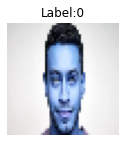

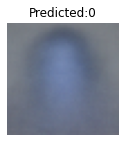

127.0.0.1 - - [04/Jun/2021 19:02:01] "GET /api?path=image_picker1734741249662009787.jpg&token=082dd02c-6125-4c6b-b036-c944e16e52d9 HTTP/1.1" 200 -


In [ ]:
if __name__ == '__main__':
    app.run(host='0.0.0.0')
    #app.run()